In [6]:
import nengo
from nengo.processes import WhiteSignal
import matplotlib.pyplot as plt
import numpy as np
from utils import get_w

%matplotlib inline
%load_ext nengo.ipynb

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [47]:
n_neurons = 200
SEED=0

with nengo.Network(seed=SEED) as train_model:
    in_nd = nengo.Node(WhiteSignal(10, high=5))
    ens = nengo.Ensemble(200, 1, neuron_type=nengo.LIFRate())
    nengo.Connection(in_nd, ens)
    
    p_target = nengo.Probe(in_nd)
    p_rates = nengo.Probe(ens.neurons)

In [48]:
with nengo.Simulator(train_model) as sim_train:
    sim_train.run(10)

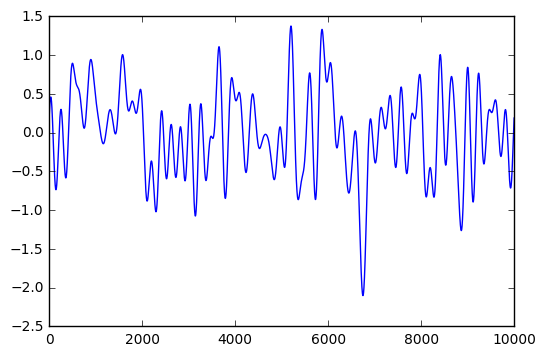

In [49]:
plt.plot(sim_train.data[p_target])

In [50]:
solver = nengo.solvers.LstsqL2(reg=0.02)
b_dec, _ = solver(sim_train.data[p_rates], sim_train.data[p_target])

In [51]:
r_dec = get_w(sim_train.data[p_rates].T, sim_train.data[p_target].T, n_neurons=n_neurons)

In [35]:
print(r_dec.shape)
print(b_dec.shape)

(200, 1)
(200, 1)


In [52]:
with nengo.Network(seed=SEED) as base_model:
    in_nd = nengo.Node(lambda t: np.sin(2*np.pi*t*5))
    ens = nengo.Ensemble(200, 1, neuron_type=nengo.LIFRate())
    nengo.Connection(in_nd, ens)
    
    p_ref = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [53]:
with nengo.Simulator(base_model) as sim_base:
    sim_base.run(2)

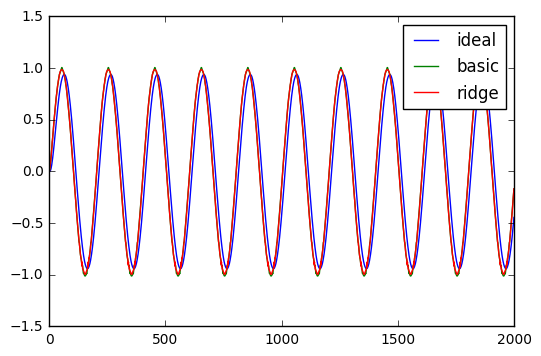

In [56]:
b_sig = np.dot(sim_base.data[p_ref], b_dec)
r_sig = np.dot(sim_base.data[p_ref], r_dec)
plt.plot(sim_base.data[p_out])
plt.plot(b_sig)
plt.plot(r_sig)
plt.legend(["ideal", "basic", "ridge"])